In [11]:
import numpy as np
import pandas as pd
from importlib import reload
import heston
import matplotlib.pyplot as plt
import levenberg_marquardt
reload(levenberg_marquardt)
reload(heston)
from heston import fHes, JacHes, MarketParameters, ModelParameters
from levenberg_marquardt import Levenberg_Marquardt
from typing import Tuple

In [2]:
df = pd.read_csv(f"../datasets/deribit_options_chain_2022-12-01_OPTIONS.csv")


In [19]:
def select_data(df: pd.DataFrame, currency: str  = "BTC"):
    # take single currency
    df = df.drop(columns = ["exchange", "open_interest", 
                    "last_price", "bid_price", "bid_amount", "bid_iv",
                           "ask_price", "ask_amount", "ask_iv", "underlying_index",
                           "delta", "gamma", "vega", "theta" ,"rho"])
    ind = [symbol.startswith(currency) for symbol in df.symbol]
    data = df[ind].reset_index(drop=True)
    #tau is time before expiration in years
    data['tau'] = (data.expiration - data.timestamp) / 1e6 / 3600 / 24 / 365
    K = data.strike_price.values
    F = data.underlying_price.values

    payoff = np.maximum(F - K, 0.0)
    payoff[data.type == 'put'] = np.maximum( K - F, 0.0)[data.type == 'put']
    data["payoff"] = payoff
    
    #inverse 
    data["inverse_payoff"] =  data["payoff"]/data["underlying_price"]
    
    data_grouped = data.groupby(['type', 'expiration', 'strike_price'])\
    .agg(lambda x: x.iloc[-1]).reset_index().drop(["timestamp"], axis=1)
    data_grouped = data_grouped[data_grouped["tau"]>0.0]
    # Only out of the money
    data_grouped = data_grouped[
        ((data_grouped["type"] == "call") & 
        (data_grouped["underlying_price"] <= data_grouped["strike_price"])) | 
       ((data_grouped["type"] == "put") &
        (data_grouped["underlying_price"] >= data_grouped["strike_price"])) 
    ]
    data_grouped["mark_price_usd"] = data_grouped["mark_price"] * data_grouped["underlying_price"]
    data_grouped = data_grouped[data_grouped["strike_price"]<=10_000]
    return data_grouped
    
    

In [20]:
sample = select_data(df, currency = "ETH")

In [119]:
# sing_exp = sample[sample["expiration"] == sample.sample(1).iloc[0].expiration]
sing_exp = sample.copy()
karr = sing_exp.strike_price.to_numpy(dtype=np.float64)
carr = sing_exp.mark_price_usd.to_numpy(dtype=np.float64)
tarr = sing_exp.tau.to_numpy(dtype=np.float64)
r_val = np.float64(0.0)
S_val = np.float64(sing_exp.underlying_price.mean())
market = MarketParameters(K=karr, T=tarr, S=S_val, r=r_val, C = carr)
typ = np.where(sing_exp["type"] =="call", True, False)

In [120]:
def proj_heston( heston_params : np.ndarray )->np.ndarray:
    """
        This funciton project heston parameters into valid range
        Attributes:
            heston_params(np.ndarray): model parameters
        
        Returns:
            heston_params(np.ndarray): clipped parameters
    """
    eps = 1e-4
    for i in range(len(heston_params) // 5):
        a, b, c, rho, v0 = heston_params[i * 5 : i * 5 + 5]
        a = np.clip(a, eps, 100.0)
        b = np.clip(b, eps, 100.0)
        c = np.clip(c, eps, 100.0)
        rho = np.clip(rho, -1 + eps, 1 - eps)
        v0 = np.clip(v0, eps, 100.0)
        heston_params[i * 5 : i * 5 + 5] = a, b, c, rho, v0
    
    return heston_params

def get_residuals( heston_params:np.ndarray ) -> Tuple[ np.ndarray, np.ndarray ]:
    '''
        This function calculates residuals and Jacobian matrix
        Args:
            heston_params(np.ndarray): model params
        Returns:
            res(np.ndarray) : vector or residuals
            J(np.ndarray)   : Jacobian
    '''
    # needed format to go
    model_parameters = ModelParameters(
            heston_params[0],
            heston_params[1],
            heston_params[2],
            heston_params[3],
            heston_params[4])
    # тут ок в целом, надо подогнать дальше и смотреть
    #  чтоб ваще те параметры подставлялись в якобиан
    C = fHes(
    model_parameters=model_parameters,
    market_parameters=market,
    )

    J = JacHes(
    model_parameters=model_parameters, 
    market_parameters=market)

    K = karr
    F = np.ones(len(K))*market.S
    weights = np.ones_like(K)
    weights = weights / np.sum(weights)
    P = C + np.exp(-market.r * market.T) * ( K - F )
    X_ = C
    X_[~typ] = P[~typ]
    res = X_ - market.C
    return res * weights,  J @ np.diag(weights)


a = np.float64(3.0)  # kappa                     |  mean reversion rate
b = np.float64(0.1)  # v_infinity               |  long term variance
c = np.float64(0.25)  # sigma                    |  variance of volatility
rho = np.float64(0.01)  # rho                    |  correlation between spot and volatility
v0 = np.float64(0.08) # init variance            | initial variance   

start_params = np.array([a, b, c, rho, v0])
res = Levenberg_Marquardt(100, get_residuals, proj_heston, start_params)
calibrated_params = np.array(res["x"], dtype = np.float64)
calibrated_params



array([ 0.17092677,  7.25311292,  3.23021918, -0.3972674 ,  0.64442593])

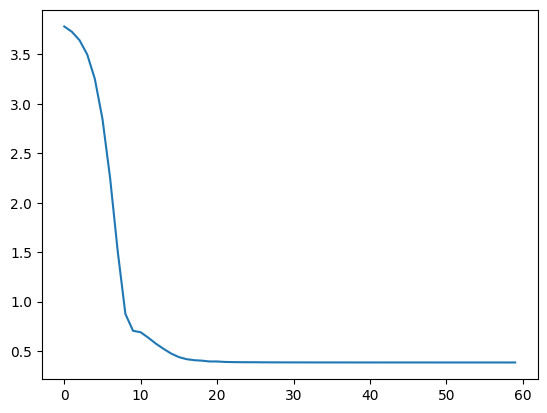

In [121]:
plt.plot(list(range(len(res["objective"]))), res["objective"])

In [92]:
# sing_exp = sample[sample["expiration"] == sample.sample(1).iloc[0].expiration]
# plt.scatter(sing_exp["strike_price"], sing_exp["mark_iv"])

In [122]:
calibrated_params_model = ModelParameters(
            calibrated_params[0],
            calibrated_params[1],
            calibrated_params[2],
            calibrated_params[3],
            calibrated_params[4])
    # тут ок в целом, надо подогнать дальше и смотреть
    #  чтоб ваще те параметры подставлялись в якобиан
calibr_C = fHes(
    model_parameters=calibrated_params_model,
    market_parameters=market,
    )
# sample["mark_price_calibrated"] = calibr_C
# sample
sing_exp["mark_price_calibrated"] = calibr_C
sing_exp.loc[sing_exp["type"] == "put", "mark_price_calibrated"] = (sing_exp["mark_price_calibrated"] + 
    np.exp(-market.r * sing_exp["tau"]) * (sing_exp["strike_price"] - sing_exp["underlying_price"]))
sing_exp

,type,expiration,strike_price,symbol,local_timestamp,mark_price,mark_iv,underlying_price,tau,payoff,inverse_payoff,mark_price_usd,mark_price_calibrated
37,call,1669968000000000,1300,ETH-2DEC22-1300-C,1669939198921651,0.0020,67.10,1276.19,0.000913,0.0,0.0,2.552380,3.585278
38,call,1669968000000000,1325,ETH-2DEC22-1325-C,1669939199011544,0.0007,82.58,1276.18,0.000913,0.0,0.0,0.893326,0.674551
39,call,1669968000000000,1350,ETH-2DEC22-1350-C,1669939196493828,0.0007,113.09,1276.21,0.000913,0.0,0.0,0.893347,0.073963
40,call,1669968000000000,1400,ETH-2DEC22-1400-C,1669939196493034,0.0000,115.00,1276.21,0.000913,0.0,0.0,0.000000,0.001771
41,call,1669968000000000,1500,ETH-2DEC22-1500-C,1669939196485910,0.0000,124.50,1276.21,0.000913,0.0,0.0,0.000000,-0.000099
...,...,...,...,...,...,...,...,...,...,...,...,...,...
627,put,1695974400000000,800,ETH-29SEP23-800-P,1669939196500957,0.1082,89.11,1273.18,0.825571,0.0,0.0,137.758076,141.108619
628,put,1695974400000000,900,ETH-29SEP23-900-P,1669939196497178,0.1381,86.64,1273.18,0.825571,0.0,0.0,175.826158,175.952051
629,put,1695974400000000,1000,ETH-29SEP23-1000-P,1669939196500921,0.1687,83.35,1273.18,0.825571,0.0,0.0,214.785466,215.430810
630,put,1695974400000000,1100,ETH-29SEP23-1100-P,1669939196492737,0.2084,82.22,1273.18,0.825571,0.0,0.0,265.330712,259.861224
